In [2]:
import pandas as pd

#load dataset
file_path = '/Users/abubakaral-faki/Documents/Data Project/MPV1/data/interim/v3_accepted_loans.csv'
accepted_loans_eda = pd.read_csv(file_path)

/var/folders/yj/v54tzbn14gb70ts6s0j5s3xm0000gn/T/ipykernel_43453/2454467369.py:7: DtypeWarning: Columns (17,47,57,116,127,128,129,132,133,134,137,143,144,145,153) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loans_eda = pd.read_csv(file_path)


## Correlations between key variables analyzed during Underwriting

In [131]:
numeric_columns = accepted_loans_eda.select_dtypes(include = ['float64', 'int64']).columns

relevant_columns = ['annual_inc','loan_amnt', 'emp_length', 'funded_amnt', 'int_rate', 'installment',
    'dti', 'fico_range_low', 'fico_range_high', 'revol_util', 'bc_util',
    'all_util', 'acc_open_past_24mths', 'delinq_2yrs', 'inq_last_6mths'   
]

# Ensure relevant columns exist in the dataset
filtered_columns = [col for col in relevant_columns if col in numeric_columns]

# Define correlation matrix
correlation_matrix = accepted_loans_eda[filtered_columns].corr()

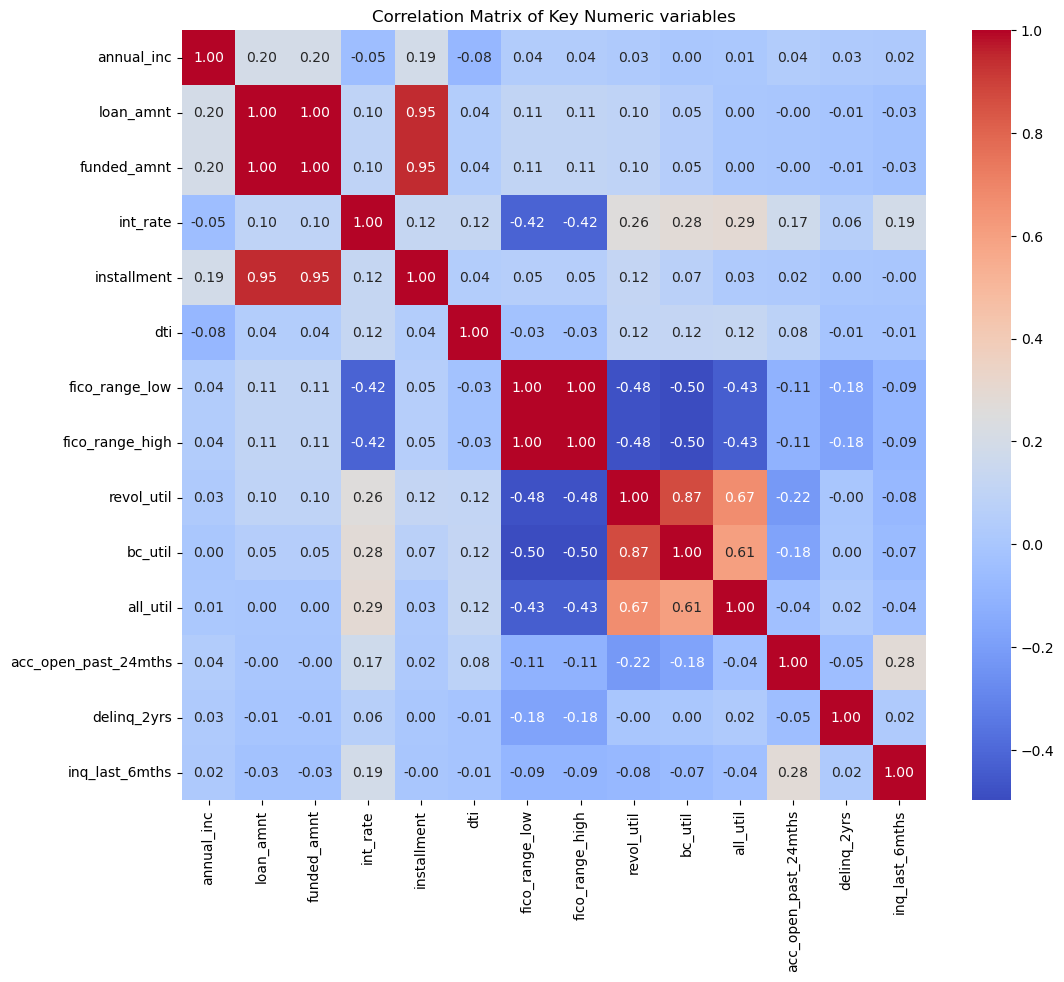

In [133]:
# Visualize Correlation Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", cbar = True)
plt.title("Correlation Matrix of Key Numeric variables")
plt.show()

## Observations

LendingCLub seems to have a good underwriting process

### Debt-to-income ratio (dti)
dti has weak correlation with most variables.

LendingCLub seems not prioritize debt-to-income ratio (d.t.i) of a borrower as d.t.i doesn't influence key metrics like loan interest rate, loan amount (loan_amnt) or FICO scores.

#### Potential Concern

If dti is not adequately weighted during the underwriting process then we may have cases where borrowers with high debt to income ratio get approved for loans they may struggle to service in the future.

Borrowers who get approved for loans with a potential for their income increasing can increase likelihood of a borrower defaulting on their loan


#### Recommendation
It can be worthwhile to consider the weighting dti in LendingClubs underwriting process to identify high risk borrowers because in our current economic climates, valuations of assets such as homes, cars, businesses are typically well above a persons income and these assets tend to increase in price faster than incomes.



In [6]:
import hvplot.pandas

# Calculate the percentages of each loan status
loan_status_percentages = (accepted_loans_eda['loan_status'].value_counts(normalize=True) * 100)

# Plot the percentages
loan_status_percentages.hvplot.bar(
    title="Status of All Loans", 
    xlabel='Loan Status', 
    ylabel='Percentage (%)', 
    width=800, 
    height=600,
    rot=45  # Rotate x-axis labels for better readability, if needed
)


:Bars   [loan_status]   (proportion)

In [7]:
application_types = (accepted_loans_eda['application_type'].value_counts(normalize = True) * 100)

application_types.hvplot.bar(
    title = "Individual vs Joint Loan Applications (%)",
    xlabel = "Application Type",
    ylabel = "Percentage (%)",
    width = 600,
    height = 400,
    rot = 45

)

:Bars   [application_type]   (proportion)

## Analysis of individual loan applications

In [10]:
# Examine distribution of annual incomes

pd.set_option('display.float_format', '{:.2f}'.format)
accepted_loans_eda['annual_inc'].describe()

count     2260544.00
mean        77991.83
std        112698.45
min             0.00
25%         46000.00
50%         65000.00
75%         93000.00
max     110000000.00
Name: annual_inc, dtype: float64

A borrower has an unusally high income of $110,000,000

### Investigate Outlier Incomes for individual loan applications

In [123]:
#Identify Outlier observations

import hvplot.pandas

#Box Plot

accepted_loans_eda.hvplot.box(
    
    y = 'annual_inc',
    title = 'Annual Incomes Box Plot',
    height=600, 
    width=800

)


:BoxWhisker   (annual_inc)

In [118]:
# Calculate interquartile range to investigate extreme values

# Calculate Q1 and Q2
Q1 = accepted_loans_eda['annual_inc'].quantile(0.25)
Q3 = accepted_loans_eda['annual_inc'].quantile(0.75)

# Calculate Interquartile range
IQR = Q3 - Q1

# Compute lower and upper bound
lower_bound = max(0, Q1 - 1.5 * IQR) # Make lower bound zero because we know incomes can't be negative
upper_bound = Q3 + 1.5 * IQR

# Print out Q1, Q3, IQR
print(f"Q1: ${Q1}, Q3: ${Q3}, IQR: ${IQR}")

# Print out Lower and upper bound
print(f'Lower Bound: ${lower_bound}')
print(f'Upper Bound: ${upper_bound}')

# Filter for Outliers
outliers = accepted_loans_eda[(accepted_loans_eda['annual_inc'] < lower_bound) | 
                             (accepted_loans_eda['annual_inc'] > upper_bound)]

# Summary Stats of outliers incomes   
print('\n\n')
print(outliers['annual_inc'].describe())

# Examine records of outlier incomes
key_vars = ['loan_amnt', 'annual_inc', 'int_rate', 'grade', 'emp_title', 'application_type', 'loan_purpose']

outlier_incomes = outliers[key_vars].sort_values(by = 'annual_inc', ascending = False)

outlier_incomes

Q1: $46000.0, Q3: $93000.0, IQR: $47000.0
Lower Bound: $0
Upper Bound: $163500.0



count      110034.00
mean       251484.63
std        458016.88
min        163516.00
25%        180000.00
50%        200000.00
75%        250000.00
max     110000000.00
Name: annual_inc, dtype: float64


,loan_amnt,annual_inc,int_rate,grade,emp_title,application_type,loan_purpose
601093,30000.00,110000000.00,9.93,B,engineer,Individual,NaN
1673026,10000.00,61000000.00,11.44,B,waitress,Individual,NaN
539778,5000.00,10999200.00,18.06,D,consultant,Individual,NaN
1597047,16000.00,9930475.00,14.07,C,manager,Individual,NaN
1413727,14000.00,9757200.00,16.14,C,contract specialist,Individual,NaN
...,...,...,...,...,...,...,...
243422,28500.00,163556.32,7.89,A,city manager,Individual,NaN
1630848,35000.00,163556.22,18.25,F,mustang engineering lp,Individual,"Need to borrow 18,000 for high interest credit..."
2046045,35000.00,163552.00,11.99,B,assistant plant engineer,Individual,NaN
1327091,28000.00,163516.00,6.62,A,fiscal officer,Individual,NaN


#### Income distribution observations

We seem to have unusually high incomes in our dataset asscoaited with careers that are unlikely to bring in the associated  level of income and there is no concrete way to validate this data.

## Investigate Careers with Outlier incomes (High incomes)

We want to check if it reasonable for a career to have an income above the upper_bound

In [134]:
# Obtain number of records in a career
high_inc_careers = pd.DataFrame(outlier_incomes['emp_title'].value_counts()).reset_index()

# Obtain top ten careers with high incomes
top_20_careers = high_inc_careers[:20]


print(f'There are {high_inc_careers.shape[0]} people in high earning careers')
print('\n\n')

print(high_inc_careers.sort_values(by = 'count', ascending = False))

There are 28911 people in high earning careers



                                emp_title  count
0                                   owner   3232
1                          vice president   2859
2                                director   2811
3                               president   2420
4                               physician   2081
...                                   ...    ...
14321                infection prevention      1
14320  national manager - auto incentives      1
14319                   vp media services      1
14318                      domaine serene      1
28910            assistant plant engineer      1

[28911 rows x 2 columns]


In [135]:
# Number of people in the top 20 high earning jobs

print(f"There are {high_inc_careers[high_inc_careers['emp_title'].isin(top_20_careers['emp_title'])]['count'].sum()} people in the top 20 high earning careers")

There are 28033 people in the top 20 high earning careers


In [136]:
# Distribution of people in the top 20 high earning jobs

print(high_inc_careers.sort_values(by = 'count', ascending = False)[:20])

                emp_title  count
0                   owner   3232
1          vice president   2859
2                director   2811
3               president   2420
4               physician   2081
5                 manager   1682
6                attorney   1450
7                     ceo   1288
8                   sales   1278
9         general manager   1199
10          sales manager   1106
11                partner   1046
12      managing director   1022
13  senior vice president    851
14      financial advisor    755
15                     vp    674
16     executive director    621
17        project manager    577
18         senior manager    544
19       registered nurse    537


In [137]:
key_vars = ['loan_amnt', 'annual_inc', 'int_rate', 'grade', 'emp_title', 'application_type', 'loan_purpose']

print(examine_outliers[examine_outliers['emp_title'] == 'director'][key_vars].sort_values(by = 'annual_inc', ascending = False))

print(examine_outliers[examine_outliers['emp_title'] == 'director']['annual_inc'].describe())



         loan_amnt  annual_inc  int_rate grade emp_title application_type  \
1719171   28000.00  8300000.00     15.99     C  director       Individual   
1363068   35000.00  1600000.00     14.47     C  director       Individual   
2196523    8875.00  1111011.00      5.32     A  director       Individual   
288414    30000.00  1000000.00      8.18     B  director       Individual   
611824    35000.00  1000000.00      7.97     A  director       Individual   
...            ...         ...       ...   ...       ...              ...   
2250778   12000.00   164000.00      8.99     B  director       Individual   
831342     5000.00   164000.00     15.02     C  director       Individual   
1011839   30000.00   164000.00     15.31     C  director       Individual   
979859    22400.00   164000.00     16.99     D  director       Individual   
1230615   14000.00   164000.00      7.69     A  director       Individual   

        loan_purpose  
1719171          NaN  
1363068          NaN  
219652

In [138]:
# Investigate why individual loans applications with an annual income of less than $5 were still approved

accepted_loans_eda[accepted_loans_eda['annual_inc'] <= 5][['annual_inc', 'annual_inc_joint', 'loan_amnt','application_type']]

,annual_inc,annual_inc_joint,loan_amnt,application_type
18202,0.00,185000.00,20000.00,Joint App
65619,0.00,40988.00,3700.00,Joint App
421687,0.00,136000.00,40000.00,Joint App
422303,0.00,200000.00,40000.00,Joint App
422361,0.00,50000.00,3000.00,Joint App
...,...,...,...,...
2228307,0.00,55000.00,18000.00,Joint App
2230229,0.00,32000.00,10000.00,Joint App
2231300,1.00,150001.00,15000.00,Joint App
2232681,0.00,85500.00,23950.00,Joint App


Looks like we have incomes of $5.00 or less had joint applications so we will analyze incomes by joint applications and individual applications.

## What income range do we lend to the most?

In [139]:
# Filter data for individual applications that are 'Fully Paid or Charged Off'

ind_apps = accepted_loans_eda[(accepted_loans_eda['annual_inc'] > 0) & 
                              (accepted_loans_eda['loan_status'].notnull()) & 
                              (accepted_loans_eda['application_type'] == 'Individual') &
                              (accepted_loans_eda['loan_status'].isin(['Fully Paid', 'Charged Off']))]

In [140]:
# Filter for fully paid and charged off loans

filtered_data = ind_apps[ind_apps['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [147]:
import pandas as pd
import hvplot.pandas

# Create income bins
ind_apps_plot = ind_apps.copy()

ind_apps_plot['income_bin'] = pd.cut(
    ind_apps_plot['annual_inc'],
    bins=[0, 25000, 50000, 75000, 100000, 150000, 200000, 500000, 1000000],
    labels=['$0-25k', '$25-50k', '$50-75k', '$75-100k', '$100-150k', '$150-200k', '$200-500k', '$500k+'],
    right=False
)

# Aggregate Counts by income bin and loan status
income_status_counts = ind_apps_plot.groupby(['income_bin', 'loan_status']).size().unstack().fillna(0)

# Convert counts to percentages relative to the overall number of borrowers
overall_counts = income_status_counts.sum().sum()
income_status_percentages = income_status_counts.div(overall_counts) * 100

# Convert the DataFrame for hvPlot
income_status_percentages = income_status_percentages.reset_index().melt(id_vars='income_bin', var_name='Loan Status', value_name='Percentage')

# Define the color mapping
custom_colors = {
    'Fully Paid': '#3498DB',
    'Charged Off': '#FF5733',  
}

# Plot stacked bar chart using hvPlot
hvplot_chart = income_status_percentages.hvplot.bar(
    x='income_bin', 
    y='Percentage', 
    by='Loan Status', 
    stacked=True, 
    title='What income range do we lend to the most?', 
    xlabel='Income Bin', 
    ylabel='Percentage of Overall Borrowers', 
    height=600, 
    width=800, 
    rot=45,
    color=[custom_colors[status] for status in income_status_percentages['Loan Status'].unique()],  # Apply colors
    legend='top_right'
)

hvplot_chart


:Bars   [income_bin,Loan Status]   (Percentage)

## What is the risk of Charge Off across income ranges?

In [148]:
# Calculate the total number of loans per income bin
total_loans_per_bin = income_status_counts.sum(axis=1)

# Calculate the number of "Charged Off" loans per income bin
charged_off_counts = income_status_counts['Charged Off']

# Calculate the normalized charge-off rate (percentage of loans charged off in each bin)
charged_off_rate = (charged_off_counts / total_loans_per_bin) * 100

# Convert to a DataFrame for hvPlot
charged_off_rate_df = charged_off_rate.reset_index()
charged_off_rate_df.columns = ['Income Bin', 'Charge-Off Rate (%)']

# Plot the line graph using hvPlot
line_chart = charged_off_rate_df.hvplot.line(
    x='Income Bin',
    y='Charge-Off Rate (%)',
    title='Risk of Charge Off Across Income Buckets',
    xlabel='Income Bin',
    ylabel='Charge-Off Rate (%)',
    height=600,
    width=800,
    line_width=3  # Remove marker argument
)

line_chart



:Curve   [Income Bin]   (Charge-Off Rate (%))

Looks like as income increases risk of charge-off decreases.

## Distributions of incomes for individual Applications

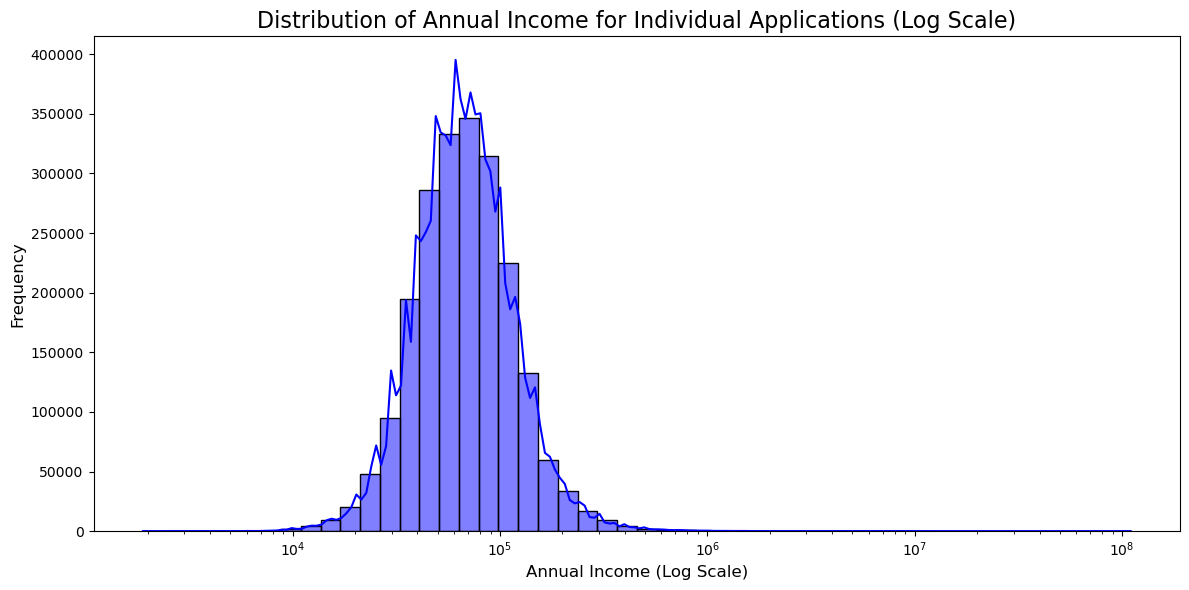

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 6))
sns.histplot(ind_apps['annual_inc'], bins = 50, kde = True, color = 'blue', log_scale = True)
plt.title('Distribution of Annual Income for Individual Applications (Log Scale)', fontsize = 16)
plt.xlabel('Annual Income (Log Scale)', fontsize = 12)
plt.ylabel('Frequency', fontsize =12)
plt.tight_layout()
plt.show()

## Distributions of incomes for individual Applications by Loan Status

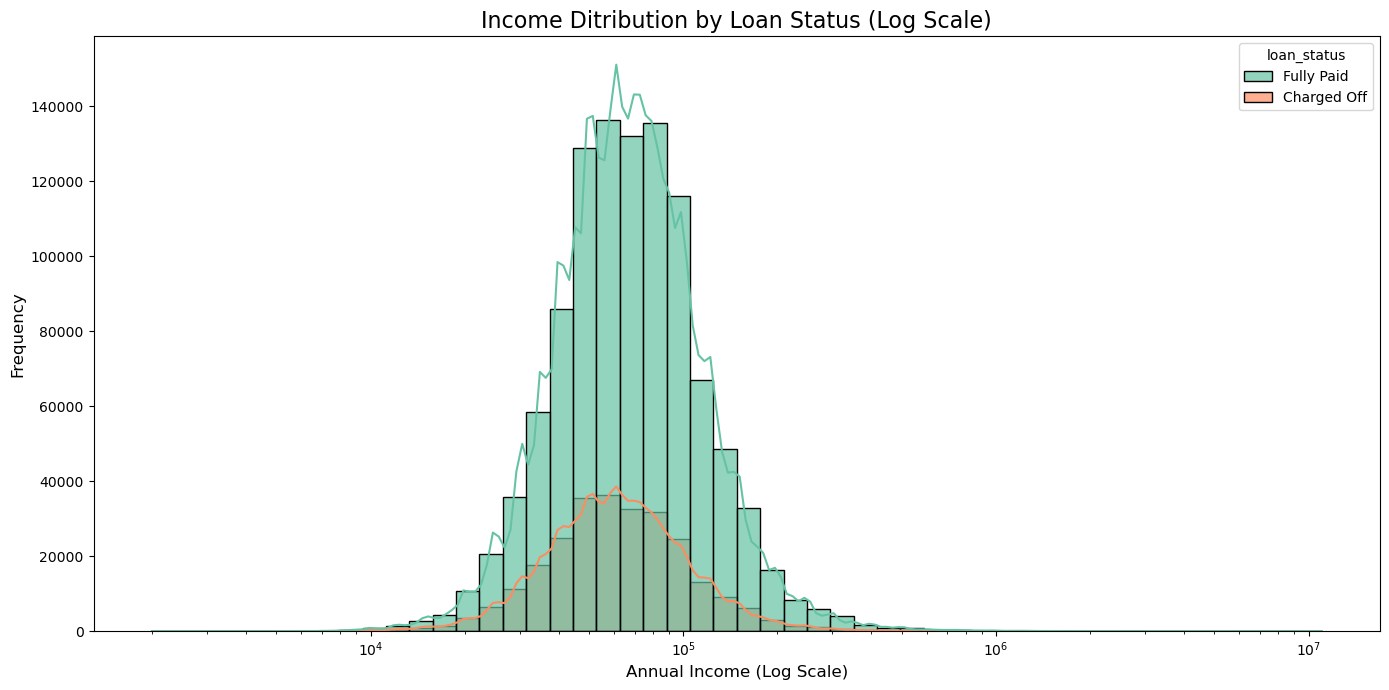

In [59]:
# Plot Income Distribution by Loan Status

plt.figure(figsize = (14, 7))
sns.histplot(
    data = filtered_data,
    x = 'annual_inc',
    hue = 'loan_status',
    bins = 50,
    kde = True,
    log_scale = True,
    palette = 'Set2',
    alpha = 0.7
)

plt.title('Income Ditribution by Loan Status (Log Scale)', fontsize = 16)
plt.xlabel('Annual Income (Log Scale)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tight_layout()
plt.show()

I would to analyze the people we lend to the most.

Do they own a home?
Do they have existing debt?
What dod they do for work?
How much do they borrow on average?
How do we reduce charge offs for that category?